In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from zipfile import ZipFile
import sys
from contextlib import contextmanager
import time
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
@contextmanager 
def timer(name: str, _align): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [7]:
def single_symbol_image(g, start_date, sample_rate):
    dataset = []
    for i in range(4, len(g[1])):
        if np.random.rand(1) > sample_rate:
            continue
        
        if g[1].iloc[i]['date'] < start_date:
            continue
        price_slice = g[1][i-4:i+1][['open', 'high', 'low', 'close']].reset_index(drop=True)
        
        if np.max(price_slice.values) == np.min(price_slice.values): # no transactions recently
            continue
        
        price_slice = (price_slice - np.min(price_slice.values))/(np.max(price_slice.values) - np.min(price_slice.values))
        price_slice = price_slice.apply(lambda x: x*31).astype(int)
        
        image = np.zeros((32, 15))
        for i in range(5):
            image[price_slice.loc[i]['open'], i*3] = 255.
            image[price_slice.loc[i]['low']:price_slice.loc[i]['high']+1, i*3+1] = 255.
            image[price_slice.loc[i]['close'], i*3+2] = 255.
    
        label_ret1 = 1 if np.sign(g[1].iloc[i]['ret1']) > 0 else 0
        label_ret5 = 1 if np.sign(g[1].iloc[i]['ret5']) > 0 else 0
        label_ret20 = 1 if np.sign(g[1].iloc[i]['ret20']) > 0 else 0
        
        entry = [image, label_ret1, label_ret5, label_ret20]
        dataset.append(entry)
    return dataset


class DataLoader():
    def __init__(self, win_size, start_date, end_date, batch_size, mode, sample_rate, shuffle):
        assert mode in ['train', 'test'], f'Type Error: {mode}'
        if mode == 'test':
           assert not shuffle, 'Test Data should not shuffle'
        self.win_size = win_size # 5 or 15
        self.start_date = start_date
        self.end_date = end_date 
        self.batch_size = batch_size
        self.mode = mode
        self.sample_rate = sample_rate
        self.shuffle = shuffle
        self.load_data()
        # self.generate_images()
        
    @timer('Load Data', '8')
    def load_data(self):
        if 'data' not in os.listdir():
            print('Download Original Tabular Data')
            os.system("mkdir data && cd data && wget 'https://cloud.tsinghua.edu.cn/f/f0bc022b5a084626855f/?dl=1' -O tabularDf.zip")
        
        with ZipFile('data/tabularDf.zip', 'r') as z:
            f =  z.open('tabularDf.csv')
            tabularDf = pd.read_csv(f, index_col=0)
            f.close()
            z.close()
            
        padding_start_date = int(str(pd.to_datetime(str(self.start_date)) - datetime.timedelta(days=40)).split(' ')[0].replace('-', ''))
        paddint_end_date = int(str(pd.to_datetime(str(self.end_date)) + datetime.timedelta(days=40)).split(' ')[0].replace('-', ''))
        self.select_df = tabularDf.loc[(tabularDf['date'] > padding_start_date) & (tabularDf['date'] < paddint_end_date)]
        
        self.select_df['ret1'] = np.zeros(self.select_df.shape[0])
        self.select_df['ret5'] = np.zeros(self.select_df.shape[0])
        self.select_df['ret20'] = np.zeros(self.select_df.shape[0])
        self.select_df['ret1'] = (self.select_df['close'].pct_change()*100).shift(-1)
        self.select_df['ret5'] = (self.select_df['close'].pct_change(5)*100).shift(-5)
        self.select_df['ret20'] = (self.select_df['close'].pct_change(20)*100).shift(-20)
        
        self.select_df = self.select_df.loc[self.select_df['date'] <= self.end_date]
        
        
    def generate_images(self):
        dataset_all = Parallel(n_jobs=32)(delayed(single_symbol_image)(g, start_date=self.start_date, sample_rate=self.sample_rate) for g in tqdm(self.select_df.groupby('code'), desc='Generating Images'))
        
        self.dataset_squeeze = []
        for symbol_data in dataset_all:
            self.dataset_squeeze = self.dataset_squeeze + symbol_data
        dataset_all = [] # clear memory
        
        
    # def next_batch():
    #     # 
        
    #     if mode == 'train':
            
    #         return new_batch, labels # new_batch: (N, 32/64, win_size*3); labels: (N, 1)
        
    #     else: 
            
            
    #         # In test_mode: one stock, one batch
    #         # symbol: stock code; datelist: list of str; new_batch: (len(datelist), 32/64, win_size*3); labels: (len(datelist), 1)
    #         return symbol, datelist, new_batch, labels
    

In [6]:
start_date, end_date = 20100101, 20111231

In [15]:
Training_ranges = [(int(start_year*1e4+1231-60), int(end_year*1e4+1231)) for start_year, end_year in zip(range(2009, 2019, 1), range(2011, 2021, 1))]
print(Training_ranges)

Test_ranges = [(int(start_year*1e4+1231-60), int(end_year*1e4+1231)) for start_year, end_year in zip(range(2011, 2021, 1), range(2012, 2022, 1))]
print(Test_ranges)

[(20091171, 20111231), (20101171, 20121231), (20111171, 20131231), (20121171, 20141231), (20131171, 20151231), (20141171, 20161231), (20151171, 20171231), (20161171, 20181231), (20171171, 20191231), (20181171, 20201231)]
[(20111171, 20121231), (20121171, 20131231), (20131171, 20141231), (20141171, 20151231), (20151171, 20161231), (20161171, 20171231), (20171171, 20181231), (20181171, 20191231), (20191171, 20201231), (20201171, 20211231)]


In [8]:
test_data_loader = DataLoader(5, 20091231, 20111231, 256, 'train', 0.04, True)

[Load Data] | 2023-04-13 16:30:00 Done | Using  7.730 seconds


In [9]:
test_data_loader.select_df

,code,date,open,high,low,close,volume,ret1,ret5,ret20
0,000001.SZ,20100105,852.76,858.14,816.85,836.60,556499.82,-1.716471,-3.648099,-8.283529
1,000001.SZ,20100106,834.80,834.80,815.77,822.24,412143.13,-1.092139,-8.471979,-1.397402
2,000001.SZ,20100107,822.24,827.62,804.28,813.26,355336.85,-0.220102,-7.417062,-1.987064
3,000001.SZ,20100108,807.87,816.85,802.49,811.47,288543.06,0.000000,-5.177024,-2.655674
4,000001.SZ,20100111,843.78,850.24,799.98,811.47,442846.02,-0.664227,-5.000801,-4.602758
...,...,...,...,...,...,...,...,...,...,...
7567129,601999.SH,20111226,8.48,8.61,8.30,8.32,34692.84,-5.649038,-8.413462,-3.605769
7567130,601999.SH,20111227,8.31,8.31,7.76,7.85,47899.84,-1.783439,-5.222930,5.732484
7567131,601999.SH,20111228,7.78,7.82,7.47,7.71,36888.07,-0.259403,-1.945525,8.690013
7567132,601999.SH,20111229,7.64,7.84,7.63,7.69,24299.21,2.340702,2.470741,7.932380


In [192]:
price_slice

,open,high,low,close
0,28,32,3,11
1,10,24,6,12
2,13,19,0,7
3,5,22,2,22
4,32,32,3,6


In [213]:
start_date

20100101

In [11]:
dataset_all = Parallel(n_jobs=32)(delayed(single_symbol_image)(g, sample_rate=0.4) for g in tqdm(select_data.groupby('code')))

100%|██████████| 2283/2283 [09:29<00:00,  4.01it/s]


In [26]:
dataset_squeeze = []
for symbol_data in dataset_all:
    dataset_squeeze = dataset_squeeze + symbol_data

In [30]:
dataset_squeeze[555][0]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.,
          0.,   0., 255.,   0.],
       [  0.,   0.,   0.,   0.,   0.,

In [183]:
price_slice

,open,high,low,close
0,29,32,9,20
1,19,19,8,12
2,12,15,2,7
3,4,9,1,6
4,24,27,0,6


In [179]:
image = np.zeros((32, 15))

In [180]:
for i in range(5):
    image[price_slice.loc[i]['open'], i*3] = 255.
    image[price_slice.loc[i]['low']:price_slice.loc[i]['high']+1, i*3+1] = 255.
    image[price_slice.loc[i]['close'], i*3+2] = 255.

(0.0, 31.0)

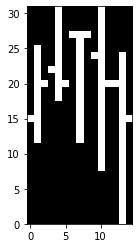

In [31]:
# plt.subplot(15*32)
plt.imshow(dataset_squeeze[555][0], cmap=plt.get_cmap('gray'))
plt.ylim((0,31))